# Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import scipy

from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
# from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, mean_squared_log_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
# from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

In [11]:
train = pd.read_csv(r'train.csv', index_col = 'id')
test = pd.read_csv(r'test.csv', index_col = 'id')
original = pd.read_csv(f'Original.csv', index_col=0)

In [12]:
train.rename(columns={'Whole weight.1':'Whole_weight_1',
                      'Whole weight.2':'Whole_weight_2',
                      'Whole weight':'Whole_weight',
                      'Shell weight':'Shell_weight'},inplace=True)
test.rename(columns={'Whole weight.1':'Whole_weight_1',
                     'Whole weight.2':'Whole_weight_2',
                     'Whole weight':'Whole_weight',
                     'Shell weight':'Shell_weight'},inplace=True)
original.rename(columns={'Shucked_weight':'Whole_weight_1',
                     'Viscera_weight':'Whole_weight_2'},inplace=True)

In [13]:
train.head(3)
# test.head(3)
# original.head(3)

,Sex,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings
id,,,,,,,,,
0,F,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.240,11
1,F,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.320,11
2,I,0.16,0.11,0.025,0.0210,0.0055,0.0030,0.005,6


In [14]:
# test.shape #(60411, 8)

# Descriptive Statistics

In [15]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='pink')


,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Rings,int64,90615,28,0.030900,0,0.000000,9.696794,3.176221,1.000000,8.000000,9.000000,11.000000,29.000000
Length,float64,90615,157,0.173260,0,0.000000,0.517098,0.118217,0.075000,0.445000,0.545000,0.600000,0.815000
Diameter,float64,90615,126,0.139050,0,0.000000,0.401679,0.098026,0.055000,0.345000,0.425000,0.470000,0.650000
Height,float64,90615,90,0.099321,0,0.000000,0.135464,0.038008,0.000000,0.110000,0.140000,0.160000,1.130000
Whole_weight,float64,90615,3175,3.503835,0,0.000000,0.789035,0.457671,0.002000,0.419000,0.799500,1.067500,2.825500
Whole_weight_1,float64,90615,1799,1.985323,0,0.000000,0.340778,0.204428,0.001000,0.177500,0.330000,0.463000,1.488000
Whole_weight_2,float64,90615,979,1.080395,0,0.000000,0.169422,0.100909,0.000500,0.086500,0.166000,0.232500,0.760000
Shell_weight,float64,90615,1129,1.245931,0,0.000000,0.225898,0.130203,0.001500,0.120000,0.225000,0.305000,1.005000
Sex,object,90615,3,0.003311,0,0.000000,nan,nan,nan,nan,nan,nan,nan



* we only have 1 categorical column (Sex)

In [16]:
num_cols = list(train._get_numeric_data())
cat_cols = list(train.drop(num_cols, axis = 1))
target='Rings'
num_cols.remove(target)

# EDA

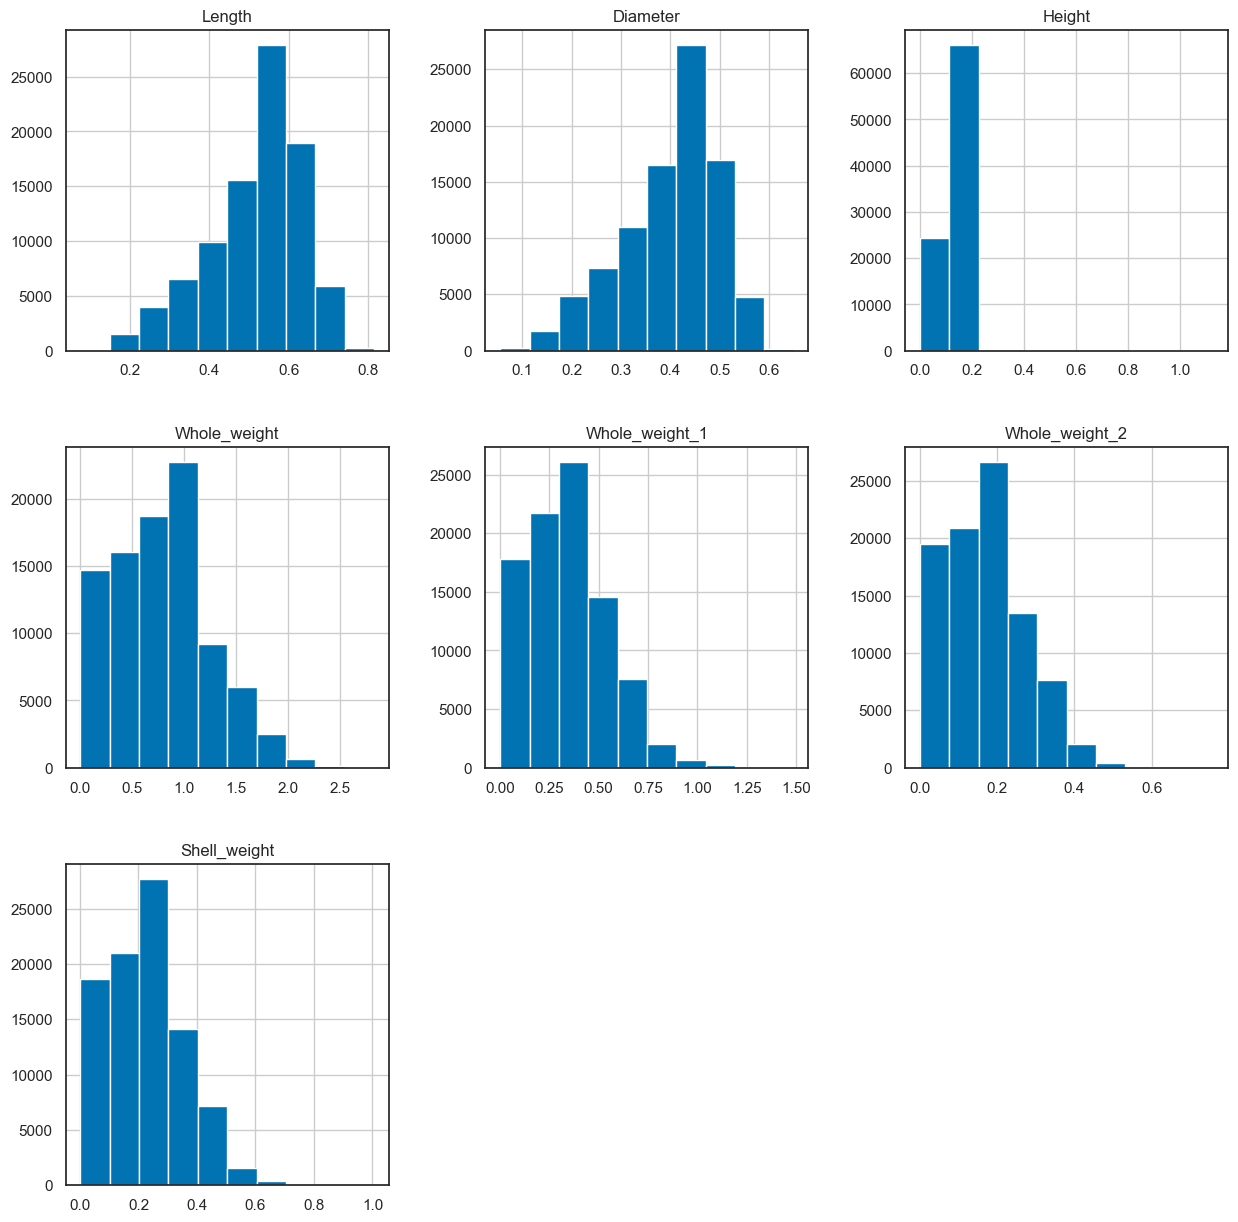

In [17]:
train[num_cols].hist(figsize=(15,15));

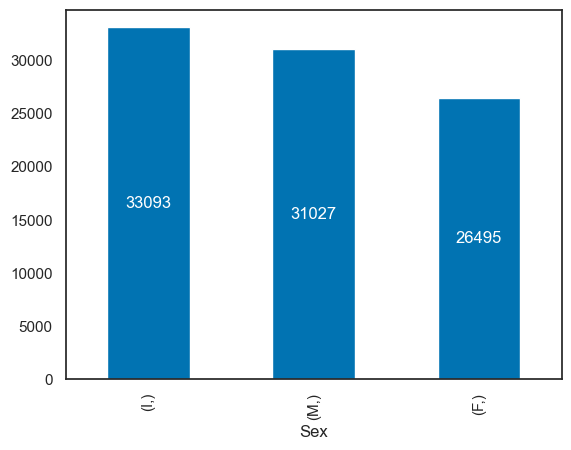

In [18]:
ax = train[cat_cols].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0],label_type='center', color='white');

## Target Distribuition

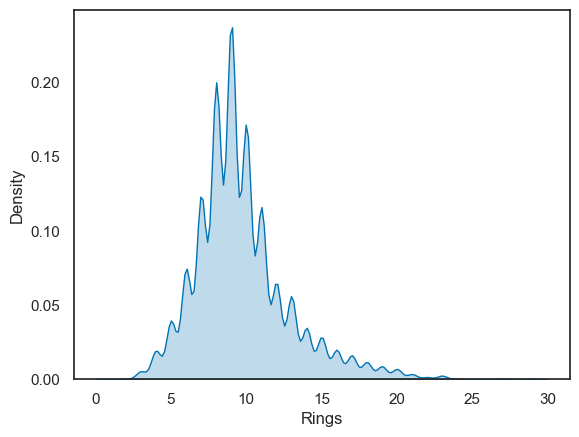

In [19]:
sns.kdeplot(train[target], fill=True);

## Log Features

In [20]:
log_features = [f for f in num_cols if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0]
log_features

['Height', 'Whole_weight', 'Whole_weight_1', 'Whole_weight_2', 'Shell_weight']

# Preprocessing

In [21]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [22]:
SEED = 42
splits = 40
kf = StratifiedKFold(n_splits = splits, random_state = SEED, shuffle = True)
def score_model(estimator, label = '', include_original_data = True, importance=False):
    

    X = train.copy()
    y = X.pop('Rings')
    

    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    train_scores, val_scores= [], []    
    
    df_importance = pd.DataFrame({'mean': 0,'std':0}, index=list(X.columns))
    

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        
        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
       
        if include_original_data:
            X_train = pd.concat([X_train, original.drop(['Rings'],axis=1)])
            y_train = pd.concat([y_train,original.Rings])
            
            if label=='LightGBM-sqrt':
                model.fit(X_train, np.sqrt(y_train))
                train_preds = np.square(model.predict(X_train))
                val_preds = np.square(model.predict(X_val))                
            else:
                model.fit(X_train, np.log1p(y_train))                  
                train_preds = np.expm1(model.predict(X_train))
                val_preds = np.expm1(model.predict(X_val))
        else:
            model.fit(X_train, np.log1p(y_train))      
            
        val_predictions[val_idx] += val_preds
        if label=='LightGBM-sqrt':
            test_predictions += np.square(model.predict(test)) / kf.get_n_splits()            
        else:
            test_predictions += np.expm1(model.predict(test)) / kf.get_n_splits()
        
        train_score = mean_squared_log_error(y_train, train_preds, squared = False)
        val_score = mean_squared_log_error(y_val, val_preds, squared = False)

        train_scores.append(train_score)
        val_scores.append(val_score)

        if importance:
            result_imp = permutation_importance(model, X_val, y_val,
                                               scoring=make_scorer(mean_squared_log_error,squared=False),
                                               n_repeats=5,random_state=SEED)            
            df_importance['mean'] += result_imp['importances_mean'] / kf.get_n_splits()
            df_importance['std'] += result_imp['importances_std'] / kf.get_n_splits()
                    
            

    if importance:
        display(df_importance)
        
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')

    return val_scores, val_predictions, test_predictions

# Models (Why these models)

* For hyperparameter tuning I used optuna.

In [ ]:
xgboost_params = {
    'max_depth': 10, 
    'verbosity': 0,
    'random_state':SEED,
    'booster': 'gbtree',
    'n_estimators': 1137, 
    'tree_method': 'hist',
    'min_child_weight': 7, 
    'grow_policy': 'lossguide', 
    'gamma': 0.03816426816838989, 
    'subsample': 0.486382907668344, 
    'objective': 'reg:squarederror',
    'reg_lambda': 1.7487237399420372, 
    'reg_alpha': 0.013043045359306716,
    'learning_rate': 0.011733966748427322, 
    'colsample_bytree': 0.5748511749872887, 
}

lgbm_params = {
     'metric':'rmse', 
     'verbosity': -1,
     'max_depth': 15,
     'random_state':SEED,
     'num_leaves': 138, 
     'n_estimators': 913, 
     'boosting_type': 'gbdt', 
     'min_child_samples': 34, 
     'objective':'regression', 
     'subsample_for_bin': 185680, 
     'subsample': 0.799314727120346, 
     'reg_alpha': 5.916235901972299e-09, 
     'reg_lambda': 6.943912907338958e-08, 
     'learning_rate': 0.01851440025520457, 
     'colsample_bytree': 0.4339090795122026, 
}

catboost_params = {
    'depth': 15, 
    'max_bin': 464, 
    'verbose': False,
    'random_state':SEED,
    'task_type': 'CPU', 
    'eval_metric': 'RMSE', 
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 8.365422739510098, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.09992185242598203, 
}

lgbm_params2 = {'n_estimators': 1000, 
                'learning_rate': 0.038622511348472645, 
                'colsample_bytree': 0.5757189042456357,
                'reg_lambda': 0.09664116733307193, 
                'min_child_samples': 87,
                'num_leaves': 43, 
                'verbosity': -1} 


In [ ]:
# lgbm_sqrt_params = {'n_estimators': 1000, 
#                     'learning_rate': 0.038622511348472645, 
#                     'colsample_bytree': 0.5757189042456357, 
#                     'reg_lambda': 0.09664116733307193, 
#                     'min_child_samples': 87, 
#                     'num_leaves': 43, 
#                     'verbosity': -1}
# scores['LightGBM-sqrt'],oof['LightGBM-sqrt'],test_preds['LightGBM-sqrt'] = score_model(make_pipeline(ColumnTransformer([('log', 
#                                        FunctionTransformer(np.log1p), log_features)],
#                                        remainder='passthrough',verbose_feature_names_out=False),
#                                        TargetEncoder(cols=cat_cols),
#                                        LGBMRegressor(**lgbm_sqrt_params)),'LightGBM-sqrt')

In [ ]:
# from https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488283, thanks @siukeitin
# def msle_loss(y_true, y_pred):
#     y_pred = np.maximum(y_pred, -1+1e-6)
#     return ((np.log1p(y_pred)-np.log1p(y_true))/(1+y_pred), 
#             (1-np.log1p(y_pred)+np.log1p(y_true))/(1+y_pred)**2)

# scores['lgbm_msle'],oof['lgbm_msle'],test_preds['lgbm_msle'] = score_model(make_pipeline(ColumnTransformer([('log', 
#                                        FunctionTransformer(np.log1p), log_features)],
#                                        remainder='passthrough',verbose_feature_names_out=False),
#                                         MEstimateEncoder(cols=['Sex']),
#                                        LGBMRegressor(verbose=0,
#                                                      random_state=SEED,
#                                                      objective=msle_loss
#                                                      )),'LGBM_MSLE')

In [ ]:
scores['lgbm_ohe'],oof['lgbm_ohe'],test_preds['lgbm_ohe'] = score_model(make_pipeline(ColumnTransformer([('log', 
                                       FunctionTransformer(np.log1p), log_features)],
                                       remainder='passthrough',verbose_feature_names_out=False),
                                       OneHotEncoder(cols=cat_cols),
                                       LGBMRegressor(verbose=0,**lgbm_params)),'LGBM')

In [ ]:
scores['lgbm_te'],oof['lgbm_te'],test_preds['lgbm_te'] = score_model(make_pipeline(ColumnTransformer([('log', 
                                      FunctionTransformer(np.log1p), log_features)],
                                      remainder='passthrough',verbose_feature_names_out=False),
                                      TargetEncoder(cols=cat_cols),
                                      LGBMRegressor(verbose=0,
                                                    **lgbm_params)),'LGBM_TE')

In [ ]:
scores['lgbm_me'],oof['lgbm_me'],test_preds['lgbm_me'] = score_model(make_pipeline(ColumnTransformer([('log', 
                                       FunctionTransformer(np.log1p), log_features)],
                                       remainder='passthrough',verbose_feature_names_out=False),
                                       MEstimateEncoder(cols=['Sex']),                                               
                                       LGBMRegressor(verbose=0,**lgbm_params2)),'LGBM_ME')

In [ ]:
scores['xgb'],oof['xgb'],test_preds['xgb'] = score_model(make_pipeline(ColumnTransformer([('log', 
                                      FunctionTransformer(np.log1p), log_features)],
                                      remainder='passthrough',verbose_feature_names_out=False),
                                      OneHotEncoder(cols=cat_cols),
                                      XGBRegressor(**xgboost_params)),'XGB')

In [ ]:
scores['catboost'],oof['catboost'],test_preds['catboost'] = score_model(make_pipeline(ColumnTransformer([('log', 
                                      FunctionTransformer(np.log1p), log_features)],
                                      remainder='passthrough',verbose_feature_names_out=False),                                      
                                      CatBoostRegressor(**catboost_params, cat_features=['Sex'])),'CatBoost')

In [ ]:
model = TransformedTargetRegressor(Ridge(positive=True,tol=1e-6),
                                   func=np.log1p,
                                   inverse_func=np.expm1)
model.fit(oof,train.Rings)
w = model.regressor_.coef_
w /= w.sum()
display(w)

# Score models

In [ ]:
ax = plt.subplot()
wplot = pd.DataFrame(w, list(oof))
wplot.plot(kind='pie',y=0,autopct="%.0f%%",ax=ax)
ax.legend( bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylabel('weights');

In [ ]:
scores['ensemble'] = mean_squared_log_error(train.Rings,oof.to_numpy() @ w,squared=False)

In [ ]:
ax = scores.mean().sort_values(ascending=False).plot(kind='barh')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
ax.patches[-1].set_facecolor('green');

# Submission

In [ ]:
predictions = test_preds.to_numpy() @ w

In [ ]:
y_pred = predictions

In [ ]:
submission = test.copy()
submission['Rings'] = y_pred
submission['Rings'] = np.where(submission["Rings"].between(27.5, 29), 29, submission["Rings"])
submission.Rings.to_csv('submission.csv')